# Исследование рынка о заведениях общественного питания в Москве

Цель исследования: изучить рынок общественного питания в Москве с целью оценить перспективы развития, определить форму и оптимальное базирование открывающегося полностью автоматизированного кафе нового типа.

## Обзор файла и подготовка данных к исследованию

In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"
import numpy as np
import seaborn as sns
from numpy import median
from io import BytesIO
import requests
import kaleido
import warnings
warnings.filterwarnings("ignore")



In [207]:
rest_data = pd.read_csv('rest_data.csv')

In [208]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [209]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


В файле имеются записи с number=0, порядка 10% от общего списка.  Возможно,что это заведения, работающие только "на вынос", например, киоски при кафе. 

In [210]:
rest_data[rest_data['number']==0]

,id,object_name,chain,object_type,address,number
137,115498,Пекарня & Донер,нет,закусочная,"город Москва, Бутырская улица, дом 9, корпус 2",0
154,152556,Шаурма в пите,нет,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 72, корпус 2",0
157,149568,Суши,нет,предприятие быстрого обслуживания,"город Москва, улица Маршала Василевского, дом ...",0
190,126956,"Шаурма, куры-гриль",нет,предприятие быстрого обслуживания,"город Москва, 1-я Владимирская улица, дом 21",0
195,149531,"Шаурма, куры-гриль",нет,предприятие быстрого обслуживания,"город Москва, 2-я Владимирская улица, дом 44/10",0
...,...,...,...,...,...,...
15334,211228,МИЛТИ,да,магазин (отдел кулинарии),"город Москва, Дубравная улица, дом 34/29",0
15335,211221,МИЛТИ,да,магазин (отдел кулинарии),"город Москва, Пятницкое шоссе, дом 3",0
15336,211209,Готовые блюда Милти,да,предприятие быстрого обслуживания,"город Москва, Ореховый бульвар, дом 22А",0
15337,208477,Милти,да,предприятие быстрого обслуживания,"город Москва, 3-й Крутицкий переулок, дом 18",0


Как видно из info() пропущенных значений в файле нет.Но для предстоящго исследования необходимо из адреса вычленить отдельно улицу. 

In [211]:
addresses=rest_data[['id','address']]

In [212]:
addresses[['len','a0','a1','a2','a3','a4','a5','a6']]= addresses['address'].apply(
lambda x:pd.Series([len(x.split(','))] + x.split(',')[0:7])
)
addresses.head()

,id,address,len,a0,a1,a2,a3,a4,a5,a6
0,151635,"город Москва, улица Егора Абакумова, дом 9",3,город Москва,улица Егора Абакумова,дом 9,NaN,NaN,NaN,NaN
1,77874,"город Москва, улица Талалихина, дом 2/1, корпус 1",4,город Москва,улица Талалихина,дом 2/1,корпус 1,NaN,NaN,NaN
2,24309,"город Москва, Абельмановская улица, дом 6",3,город Москва,Абельмановская улица,дом 6,NaN,NaN,NaN,NaN
3,21894,"город Москва, Абрамцевская улица, дом 1",3,город Москва,Абрамцевская улица,дом 1,NaN,NaN,NaN,NaN
4,119365,"город Москва, Абрамцевская улица, дом 9, корпус 1",4,город Москва,Абрамцевская улица,дом 9,корпус 1,NaN,NaN,NaN


In [213]:
addresses['a1']=addresses['a1'].str.strip()
addresses['a2']=addresses['a2'].str.strip()
addresses['a3']=addresses['a3'].str.strip()
addresses['a4']=addresses['a4'].str.strip()
addresses['a5']=addresses['a5'].str.strip()
addresses['a6']=addresses['a6'].str.strip()

In [214]:
addresses['len'].value_counts()

3    8187
4    6695
5     346
6     117
2      20
7       1
Name: len, dtype: int64

Как выяснилось  адреса не структурированы, строки имеют разное количество элементов.Более того, в файле имеются разные населенные пункты, которые до 2012 года не входили в Москву, а значит там могут быть одинаковые названия улиц. Поэтому я на всякий случай оставляю колонку с названием населенного пункта 'a0',а названия улиц буду собирать в колонке 'a1'. 

In [215]:
addresses['a0'].value_counts()

город Москва                     15295
улица Ленинская Слобода              4
Николоямская улица                   4
улица Льва Толстого                  3
Солянский тупик                      3
город Московский                     3
Партизанская улица                   2
Ленинградский проспект               2
Таганская площадь                    2
2-я Брестская улица                  2
Бауманская улица                     2
Софийская набережная                 1
Дербеневская улица                   1
Шарикоподшипниковская улица          1
поселение Михайлово-Ярцевское        1
Большая Серпуховская улица           1
Суворовская площадь                  1
1-й Нагатинский проезд               1
Большая Бронная улица                1
Калашный переулок                    1
Погодинская улица                    1
Митинская улица                      1
Новоданиловская набережная           1
5-й Котельнический переулок          1
улица Каманина                       1
Вознесенский переулок    

Передвинем названия улиц в 'a1'.

In [216]:
addresses.loc[(~addresses['a0'].str.startswith('город'))&(~addresses['a0'].str.startswith('поселение')), 'a6'] = addresses['a5']
addresses.loc[(~addresses['a0'].str.startswith('город'))&(~addresses['a0'].str.startswith('поселение')), 'a5'] = addresses['a4'] 
addresses.loc[(~addresses['a0'].str.startswith('город'))&(~addresses['a0'].str.startswith('поселение')), 'a4'] = addresses['a3']
addresses.loc[(~addresses['a0'].str.startswith('город'))&(~addresses['a0'].str.startswith('поселение')), 'a3'] = addresses['a2']
addresses.loc[(~addresses['a0'].str.startswith('город'))&(~addresses['a0'].str.startswith('поселение')), 'a2'] = addresses['a1']
addresses.loc[(~addresses['a0'].str.startswith('город'))&(~addresses['a0'].str.startswith('поселение')), 'a1'] = addresses['a0']
addresses.loc[(~addresses['a0'].str.startswith('город'))&(~addresses['a0'].str.startswith('поселение')), 'a0'] = 'город Москва'

In [217]:
addresses['a0'].value_counts()

город Москва                     15358
город Московский                     3
город Троицк                         1
поселение Марушкинское               1
поселение "Мосрентген"               1
поселение Сосенское                  1
поселение Михайлово-Ярцевское        1
Name: a0, dtype: int64

In [218]:
addresses['a1'].value_counts()

город Зеленоград                  232
проспект Мира                     204
Профсоюзная улица                 183
Ленинградский проспект            173
Пресненская набережная            167
                                 ... 
1-й Спасоналивковский переулок      1
улица Крутицкий Вал                 1
Коптевский бульвар                  1
Прибрежный проезд                   1
2-й Красносельский переулок         1
Name: a1, Length: 1861, dtype: int64

A названия городов и поселений переместим в 'a0' из 'a1'

In [219]:
addresses.loc[(addresses['a1'].str.startswith('город'))|(addresses['a1'].str.startswith('поселение')),'a0'] = addresses['a1']
addresses.loc[addresses['a0'] == addresses['a1'],'a1'] =addresses['a2']
addresses.loc[addresses['a1'] == addresses['a2'],'a2'] =addresses['a3']
addresses.loc[addresses['a2'] == addresses['a3'],'a3'] =addresses['a4']
addresses.loc[addresses['a3'] == addresses['a4'],'a4'] =addresses['a5']
addresses.loc[addresses['a4'] == addresses['a5'],'a5'] =addresses['a6']
addresses.loc[addresses['a5'] == addresses['a6'],'a6'] ='NaN'



In [220]:
addresses['a1'].value_counts()

проспект Мира                  204
Профсоюзная улица              183
Ленинградский проспект         173
Пресненская набережная         167
Варшавское шоссе               165
                              ... 
деревня Рассудово                1
Утренняя улица                   1
Кузьминская улица                1
улица Рословка                   1
2-й Красносельский переулок      1
Name: a1, Length: 2088, dtype: int64

Проведем некоторые манипуляции, чтобы улица попала в 'a1', в том случае, если в населенном пункте есть адреса с улицей и без,населенный пункт оставим, a в 'a1' будет номер дома.

In [221]:
def correct_street(locality):
    addresses.loc[(addresses['a1'].str.startswith(locality)),'a0'] = addresses['a1']
    addresses.loc[addresses['a0'] == addresses['a1'],'a1'] =addresses['a2']
    addresses.loc[addresses['a1'] == addresses['a2'],'a2'] =addresses['a3']
    addresses.loc[addresses['a2'] == addresses['a3'],'a3'] =addresses['a4']
    addresses.loc[addresses['a3'] == addresses['a4'],'a4'] =addresses['a5']
    addresses.loc[addresses['a4'] == addresses['a5'],'a5'] =addresses['a6']
    addresses.loc[addresses['a5'] == addresses['a6'],'a6'] ='NaN'

correct_street('посёлок Щапово')
correct_street('посёлок Коммунарка')
correct_street('село Кленово')
correct_street('деревня Рассудово')
correct_street('деревня Власово')
correct_street('деревня Фоминское')
correct_street('деревня Сосенки')
correct_street('посёлок Внуково')
correct_street('деревня Толстопальцево')
correct_street('деревня Поповка')
correct_street('деревня Картмазово')
correct_street('деревня Марушкино')
correct_street('посёлок Совхоза "Крёкшино"')
correct_street('дачный посёлок Кокошкино')
correct_street('посёлок Знамя Октября')
correct_street('посёлок Ерино')
correct_street('посёлок Рогово')
correct_street('посёлок ЛМС')
correct_street('посёлок ДСК "Мичуринец"')
correct_street('село Красное')
correct_street('ж/к "Дубровка"')
correct_street('деревня Горчаково')
correct_street('посёлок Завода Мосрентген')
correct_street('деревня Рогозинино')
correct_street('деревня Каменка')
correct_street('рабочий посёлок Киевский')
correct_street('посёлок Первомайское')
correct_street('деревня Николо-Хованское')
correct_street('деревня Колотилово')
correct_street('село Остафьево')
correct_street('деревня Мостовское')
correct_street('деревня Крёкшино')
correct_street('посёлок Курилово')

In [222]:
addresses['a1'].value_counts()

проспект Мира                  204
Профсоюзная улица              183
Ленинградский проспект         173
Пресненская набережная         167
Варшавское шоссе               165
                              ... 
корпус 1530                      1
улица Маршала Мерецкова          1
1-й Силикатный проезд            1
корпус 403А                      1
2-й Красносельский переулок      1
Name: a1, Length: 2111, dtype: int64

Проведем окончательную проверку, что осталось только то, что соответствует улице  

In [223]:
addresses['a6'] = 0

In [224]:
list_streets = ['улица','проспект','проезд','бульвар','набережная','шоссе','переулок','тупик','площадь','аллея','линия',
                'квартал','Проезд','микрорайон','корпус','километр','территория','вблизи','село Вороново','деревня Ликова',
                'деревня Говорово','деревня Ямонтово','деревня Ватутинки','деревня Дудкино','посёлок Воскресенское','деревня Десна',
               'деревня Троицкое','село Красная Пахра','деревня Овечкино','деревня Пыхтино','деревня Бунчиха','деревня Верхнее Валуево',
               'посёлок Газопровод','деревня Яковлевское','деревня Лапшинка','посёлок Акулово','деревня Сосенки','посёлок Знамя Октября',
               'посёлок Ерино','посёлок Рогово','деревня Внуково','посёлок Ульяновского Лесопарка','посёлок Фабрики имени 1 Мая',
               'посёлок Шишкин Лес','посёлок Завода Мосрентген','посёлок Остафьево','деревня Ясенки','деревня деревня Давыдково','просек',
               'деревня Каменка','рабочий посёлок Киевский','деревня Голохвастово','деревня Руднево','Столбово','деревня Саларьево','деревня Шаганино',
               'деревня Давыдково','деревня Сенькино-Секерино','деревня Бабенки','село Былово']
for street in list_streets:
    addresses.loc[(addresses['a1'].str.find(street)>=0),'a6'] = 1    
addresses[(addresses['a6']==0)&(addresses['a0']!='посёлок Коммунарка')&(addresses['a0']!='деревня Сосенки')&(addresses['a0']!='посёлок Знамя Октября')&(addresses['a0']!='посёлок Завода Мосрентген')]  

,id,address,len,a0,a1,a2,a3,a4,a5,a6
8565,80078,"город Москва, поселение Рязановское, посёлок Е...",4,посёлок Ерино,дом 1,NaN,NaN,NaN,NaN,0
8566,136432,"город Москва, поселение Рязановское, посёлок Е...",4,посёлок Ерино,дом 3,NaN,NaN,NaN,NaN,0
8582,84028,"город Москва, поселение Киевский, рабочий посё...",4,рабочий посёлок Киевский,дом 18А,NaN,NaN,NaN,NaN,0
8607,136381,"город Москва, поселение Марушкинское, посёлок ...",5,"посёлок Совхоза ""Крёкшино""",дом 7А,строение 1,NaN,NaN,NaN,0
8623,136384,"город Москва, поселение Марушкинское, посёлок ...",4,"посёлок Совхоза ""Крёкшино""",дом 2Б/Н,NaN,NaN,NaN,NaN,0
9190,162612,"город Москва, поселение Щаповское, посёлок Щап...",4,посёлок Щапово,дом 21,NaN,NaN,NaN,NaN,0
9852,170445,"город Москва, поселение Щаповское, посёлок Щап...",5,посёлок Щапово,дом 22,строение 1,NaN,NaN,NaN,0
9855,170451,"город Москва, поселение Щаповское, посёлок Щап...",4,посёлок Щапово,дом 80,NaN,NaN,NaN,NaN,0
10643,188860,"город Москва, поселение Роговское, деревня Кам...",4,деревня Каменка,дом 1Б/Н,NaN,NaN,NaN,NaN,0
11734,177463,"город Москва, поселение Киевский, рабочий посё...",4,рабочий посёлок Киевский,дом 31,NaN,NaN,NaN,NaN,0


In [225]:
addresses = addresses.drop(['address','len','a6'], axis = 1)
addresses = addresses.fillna('')

Добавим структурированные адреса к основному файлу

In [226]:
rest_data=rest_data.merge(addresses,on='id')
rest_data

,id,object_name,chain,object_type,address,number,a0,a1,a2,a3,a4,a5
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,город Москва,улица Егора Абакумова,дом 9,,,
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,город Москва,улица Талалихина,дом 2/1,корпус 1,,
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,город Москва,Абельмановская улица,дом 6,,,
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,город Москва,Абрамцевская улица,дом 1,,,
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,город Москва,Абрамцевская улица,дом 9,корпус 1,,
...,...,...,...,...,...,...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,город Москва,3-й Крутицкий переулок,дом 18,,,
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10,город Москва,улица Земляной Вал,дом 33,,,
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20,город Москва,улица Земляной Вал,дом 33,,,
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36,поселение Московский,Киевское шоссе,22-й километр,домовладение 4,строение 1,


Сделаем проверку на дубли

In [227]:
rest_data=rest_data.sort_values(by='number',ascending = False)

In [228]:
rest_data.duplicated(subset=['object_name','chain','object_type','a0','a1','a2','a3','a4','a5']).sum()

170

In [229]:
rest_data=rest_data.drop_duplicates(subset=['object_name','chain','object_type','a0','a1','a2','a3','a4','a5']).reset_index(drop=True)
rest_data

,id,object_name,chain,object_type,address,number,a0,a1,a2,a3,a4,a5
0,199696,Arena by Soho Family,нет,бар,"город Москва, Кутузовский проспект, дом 36, ст...",1700,город Москва,Кутузовский проспект,дом 36,строение 11,,
1,80291,Банкетный зал Шелк,нет,ресторан,"город Москва, Большой Саввинский переулок, дом...",1500,город Москва,Большой Саввинский переулок,дом 12,строение 10Г,,
2,27750,СТОЛОВАЯ-БУФЕТ,нет,столовая,"город Москва, улица Волхонка, дом 15",1400,город Москва,улица Волхонка,дом 15,,,
3,19719,КОМБИНАТ ПИТАНИЯ «УПРАВЛЕНИЕ АКАДЕМСЕРВИС»,нет,столовая,"город Москва, проспект Вернадского, дом 84, ст...",1288,город Москва,проспект Вернадского,дом 84,строение 1,,
4,27024,РУМ СЕРВИС,нет,ресторан,"город Москва, Кутузовский проспект, дом 2/1, с...",1200,город Москва,Кутузовский проспект,дом 2/1,строение 1,,
...,...,...,...,...,...,...,...,...,...,...,...,...
15191,158233,КОФЕ ПОИНТ,нет,кафе,"город Москва, Митинская улица, дом 36",0,город Москва,Митинская улица,дом 36,,,
15192,158814,Шаурма,нет,предприятие быстрого обслуживания,"город Москва, улица Газопровод, дом 1, корпус 6А",0,город Москва,улица Газопровод,дом 1,корпус 6А,,
15193,179610,Шаурма,нет,предприятие быстрого обслуживания,"город Москва, Лианозовский проезд, владение 4А",0,город Москва,Лианозовский проезд,владение 4А,,,
15194,202218,Шаурма,нет,предприятие быстрого обслуживания,"город Москва, Анадырский проезд, дом 8, корпус 3",0,город Москва,Анадырский проезд,дом 8,корпус 3,,


В процессе исследования дублей(сам процесс не показываю) выяснилось, что есть идентичные записи, но различающиеся id и number, решила из дублей для нашего исследования оставить записи с max number, для этого отсортировала файл по number.  

Интереса ради посмотрим, что за заведения с number=1

In [230]:
rest_data_1 = rest_data[rest_data['number']==1]
rest_data_1

,id,object_name,chain,object_type,address,number,a0,a1,a2,a3,a4,a5
13520,86404,Баскин Роббинс,да,предприятие быстрого обслуживания,"город Москва, Верхняя Красносельская улица, до...",1,город Москва,Верхняя Красносельская улица,дом 3А,,,
13521,178260,Starhit cafe,нет,предприятие быстрого обслуживания,"город Москва, Семёновская площадь, дом 1",1,город Москва,Семёновская площадь,дом 1,,,
13522,20768,Шаурма,нет,предприятие быстрого обслуживания,"город Москва, Снежная улица, дом 13, корпус 1",1,город Москва,Снежная улица,дом 13,корпус 1,,
13523,86333,Мороженое «Myyo»,нет,предприятие быстрого обслуживания,"город Москва, Верхняя Красносельская улица, до...",1,город Москва,Верхняя Красносельская улица,дом 3А,,,
13524,199244,Шаурма,нет,предприятие быстрого обслуживания,"город Москва, улица Миклухо-Маклая, дом 43",1,город Москва,улица Миклухо-Маклая,дом 43,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
13614,182845,Пиццерия на вынос,нет,предприятие быстрого обслуживания,"город Москва, улица Верхние Поля, дом 11, корп...",1,город Москва,улица Верхние Поля,дом 11,корпус 1,строение 2,
13615,193004,Донер Кебаб Хаус,нет,предприятие быстрого обслуживания,"город Москва, улица Паустовского, дом 2/34",1,город Москва,улица Паустовского,дом 2/34,,,
13616,210128,McDonalds,нет,предприятие быстрого обслуживания,"город Москва, Шереметьевская улица, дом 20",1,город Москва,Шереметьевская улица,дом 20,,,
13617,210139,O Eskimo Chistaya Liniya,нет,предприятие быстрого обслуживания,"город Москва, Шереметьевская улица, дом 20",1,город Москва,Шереметьевская улица,дом 20,,,


In [231]:
rest_data_1['object_type'].value_counts()

предприятие быстрого обслуживания    57
кафе                                 16
магазин (отдел кулинарии)             8
кафетерий                             5
столовая                              4
бар                                   3
закусочная                            3
буфет                                 3
Name: object_type, dtype: int64

Вопросы вызывают, в основном, только кафе и столовая

In [232]:
rest_data_1[(rest_data_1['object_type'] =='кафе')|(rest_data_1['object_type']=='столовая')]

,id,object_name,chain,object_type,address,number,a0,a1,a2,a3,a4,a5
13528,190756,Ибрагимов Магомед Сулейманович,нет,кафе,"город Москва, улица Сущёвский Вал, дом 5, стро...",1,город Москва,улица Сущёвский Вал,дом 5,строение 12,,
13529,145354,Кафе Карпов,нет,кафе,"город Москва, поселение Марушкинское, Киевское...",1,поселение Марушкинское,Киевское шоссе,32-й километр,владение 3,строение 1,
13534,133282,Фреш Смуси Бар,нет,кафе,"город Москва, Верхняя Красносельская улица, до...",1,город Москва,Верхняя Красносельская улица,дом 3А,,,
13545,182078,Джо кофе,нет,кафе,"город Москва, Электродная улица, дом 2, строен...",1,город Москва,Электродная улица,дом 2,строение 32,,
13547,29667,ЦЕХ,нет,столовая,"город Москва, Волгоградский проспект, дом 152,...",1,город Москва,Волгоградский проспект,дом 152,строение 1,,
13549,215097,Пекарня,нет,кафе,"город Москва, поселение Внуковское, улица Лётч...",1,поселение Внуковское,улица Лётчика Ульянина,дом 2,,,
13550,153211,Кофейня «Твой кофе»,нет,кафе,"город Москва, Большая Тульская улица, дом 19",1,город Москва,Большая Тульская улица,дом 19,,,
13552,138795,Кафе «Бистро»,нет,кафе,"город Москва, проспект Будённого, дом 16, стро...",1,город Москва,проспект Будённого,дом 16,строение 63,,
13556,175579,ШАУРМА. ГРИЛЬ,нет,кафе,"город Москва, улица Горбунова, дом 7, корпус 2",1,город Москва,улица Горбунова,дом 7,корпус 2,,
13558,29839,Специализированный цех ВИТО-1,нет,столовая,"город Москва, Магнитогорская улица, дом 19",1,город Москва,Магнитогорская улица,дом 19,,,


Как и в случае с number=0, это могут быть небольшие заведения, работающие только "на вынос". Даже если в этой выборке есть ошибки в типе или количестве, это небольшой процент, которым можно пренебречь.  

**Заключение по предобработке:** В процессе изучения предоставленного файла выяснилось, что есть записи с числом посадочных мест (number) равным нулю, порядка 10%, и менее 1% записей, где number =1.Сделан вывод, что эти записи можно отнести к заведениям, работающим только "на вынос".

Затем с целью предстоящего исследования были структурированы сведения об адресах. Элемент предшествующий номеру дома или строения (улица, деревня и т.п.) был перенесен в поле a1, а соответствующий населенный пункт -  в a0. 

Затем была сделана проверка на дубли, из дублей были оставлены значения, имеющие max number. 

## Исследование рынка

### Обзор заведений общественного питания Москвы

Сначала посмотрим общую картину общепита в Москве по данным этого файла

In [233]:
rest_count = rest_data['object_type'].value_counts().reset_index()
rest_count.columns= ['object_type','object_count']

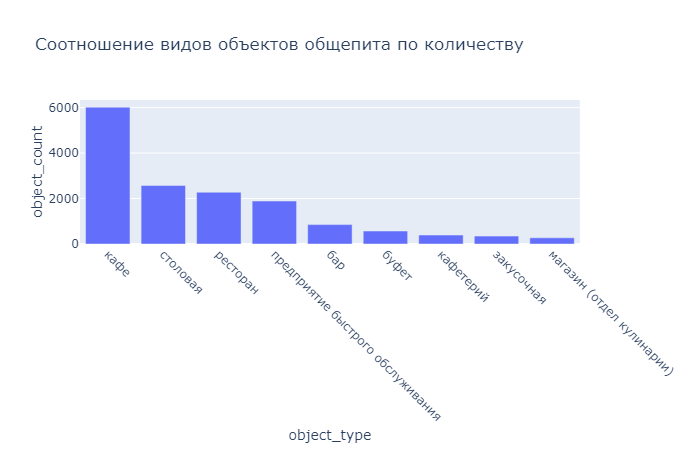

In [234]:
data = rest_count
fig = px.bar(
    data, x='object_type', y='object_count',
    title='Cоотношение видов объектов общепита по количеству'
)
fig.update_xaxes(tickangle=45)
fig.show('png') 

На графике видно,что самый распространенный вид объекта питания  - это кафе, которорых более чем в 2 раза больше остальных видов.

Теперь добавим  признак сетевой-несетевой

In [235]:
rest_chain_count = rest_data.groupby(['chain','object_type'])['id'].count().reset_index()
rest_chain_count.columns = ['chain','object_type','object_count']
rest_chain_count = rest_chain_count.sort_values(by=['chain','object_count'],ascending = False)
rest_chain_count

,chain,object_type,object_count
12,нет,кафе,4628
17,нет,столовая,2572
16,нет,ресторан,1734
15,нет,предприятие быстрого обслуживания,1107
9,нет,бар,816
10,нет,буфет,560
13,нет,кафетерий,342
11,нет,закусочная,292
14,нет,магазин (отдел кулинарии),194
3,да,кафе,1389


In [236]:
chain_no = rest_chain_count[rest_chain_count['chain']=='нет']
chain_no.columns = ['chain','object_type','object_chain_no']
chain_yes = rest_chain_count[rest_chain_count['chain']=='да']
chain_yes.columns = ['chain','object_type','object_chain_yes']
marks_chain = chain_no.merge(chain_yes,on='object_type')
marks_chain['part_y'] = (marks_chain['object_chain_yes']/(marks_chain['object_chain_no']+marks_chain['object_chain_yes'])).round(2)   
marks_chain[['object_type','object_chain_no','object_chain_yes','part_y']]

,object_type,object_chain_no,object_chain_yes,part_y
0,кафе,4628,1389,0.23
1,столовая,2572,3,0.00
2,ресторан,1734,542,0.24
3,предприятие быстрого обслуживания,1107,784,0.41
4,бар,816,37,0.04
5,буфет,560,11,0.02
6,кафетерий,342,51,0.13
7,закусочная,292,56,0.16
8,магазин (отдел кулинарии),194,78,0.29


In [237]:
print('Количество несетевых заведений=',marks_chain['object_chain_no'].sum())
print('Количество сетевых заведений=',marks_chain['object_chain_yes'].sum())

Количество несетевых заведений= 12245
Количество сетевых заведений= 2951


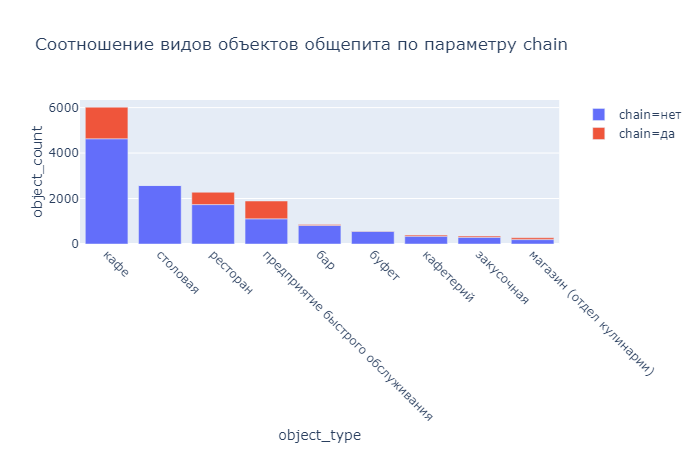

In [238]:
fig = px.bar(
    rest_chain_count,
    x='object_type',
    y='object_count',
    color='chain',
    title='Cоотношение видов объектов общепита по параметру chain'
)
fig.update_xaxes(tickangle=45)
fig.show('png')

In [239]:
only_chain_yes = rest_data[(rest_data['chain']=='да')&(rest_data['number'] > 1)]

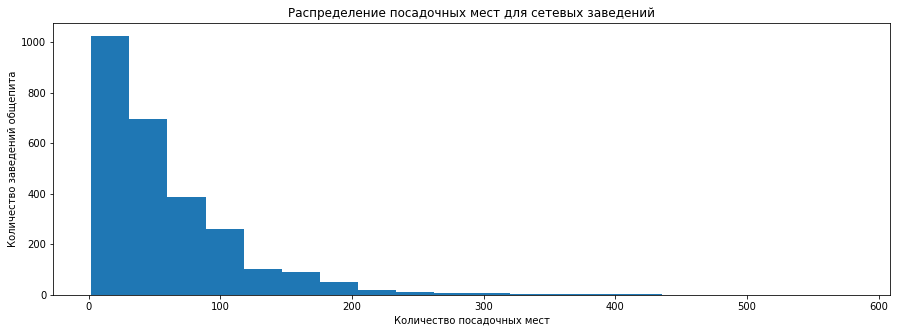

In [240]:
plt.figure(figsize = (15,5))
plt.hist(only_chain_yes['number'],bins=20); 
plt.title('Распределение посадочных мест для сетевых заведений');
plt.xlabel('Количество посадочных мест')
plt.ylabel('Количество заведений общепита')
plt.show()

Вопрос: — Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест? Ответ: оба варианта верны. Не "или", а "и".

Посмотрим среднее (по медиане) количество посадочных мест в зависимости от типа заведения

In [241]:
numbers=rest_data.groupby('object_type')['number'].median().reset_index()
numbers.columns=['object_type','number']
numbers=numbers.sort_values(by='number',ascending=False)
numbers

,object_type,number
8,столовая,103
7,ресторан,80
0,бар,35
1,буфет,32
3,кафе,32
4,кафетерий,6
6,предприятие быстрого обслуживания,6
2,закусочная,0
5,магазин (отдел кулинарии),0


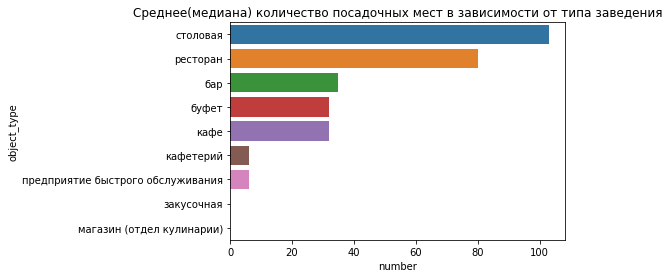

In [242]:
sns.barplot(x='number', y='object_type', data=numbers).set_title('Среднее(медиана) количество посадочных мест в зависимости от типа заведения');

In [243]:
numbers=rest_data.groupby(['object_type','chain'])['number'].median().reset_index()
numbers.columns=['object_type','chain','number']
numbers=numbers.sort_values(by=['object_type','chain'],ascending=False)
numbers

,object_type,chain,number
17,столовая,нет,103.0
16,столовая,да,120.0
15,ресторан,нет,76.0
14,ресторан,да,89.5
13,предприятие быстрого обслуживания,нет,0.0
12,предприятие быстрого обслуживания,да,25.0
11,магазин (отдел кулинарии),нет,0.0
10,магазин (отдел кулинарии),да,3.5
9,кафетерий,нет,6.0
8,кафетерий,да,8.0


In [244]:
rest_data['number'].describe()

count    15196.000000
mean        59.949000
std         74.957851
min          0.000000
25%         14.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

Большой разброс number, от 0 до 1700. Среднее и медиана "разъехались". Это означает, что надо нивелировать выбросы, причем для каждой позиции отдельно; или чтобы приблизиться к нормальному в прямом и переносном смысле среднему, лучше использовать медиану.

Из полученных данных можно сделать вывод, что сетевые заведения больше распространены в таких типах объектах как кафе, предприятия быстрого обслуживания и ресторан.В то время как среднее количество посадочных мест для этих категорий выглядят в порядке убывания: ресторан, кафе, предприятие быстрого обслуживания. В заведениях типа "столовая" самое большое среднее количество посадочных мест, а по распространенности они на втором месте после кафе, но почти в половину уступают им в количестве (2553 столовых против 5715 кафе) 

### Территориальное распространение объектов питания

Посмотрим распространение объектов питания по улицам Москвы и отдельно по районам 

In [245]:
groupped_streets=rest_data.groupby(['a0','a1'])['id'].count().reset_index()
groupped_streets.columns=['region','street','count']
groupped_streets.sort_values(by='count',ascending=False)

,region,street,count
1517,город Москва,проспект Мира,197
1132,город Москва,Профсоюзная улица,181
819,город Москва,Ленинградский проспект,172
1117,город Москва,Пресненская набережная,165
542,город Москва,Варшавское шоссе,161
...,...,...,...
933,город Москва,Мрузовский переулок,1
946,город Москва,Нагорный бульвар,1
948,город Москва,Напрудный переулок,1
949,город Москва,Нарвская улица,1


Теперь из них отберем топ 10

In [246]:
groupped_streets.sort_values(by='count',ascending=False).head(10)

,region,street,count
1517,город Москва,проспект Мира,197
1132,город Москва,Профсоюзная улица,181
819,город Москва,Ленинградский проспект,172
1117,город Москва,Пресненская набережная,165
542,город Москва,Варшавское шоссе,161
822,город Москва,Ленинский проспект,148
1514,город Москва,проспект Вернадского,127
810,город Москва,Кутузовский проспект,114
736,город Москва,Каширское шоссе,110
741,город Москва,Кировоградская улица,107


Теперь соберем по населенным пунктам

In [247]:
groupped_street_regs=rest_data.groupby(['a0'])['id'].count().reset_index()
groupped_street_regs.columns=['region','count']
groupped_street_regs.sort_values(by='count',ascending=False)

,region,count
1,город Москва,14373
0,город Зеленоград,230
30,поселение Московский,67
2,город Московский,66
42,посёлок Коммунарка,59
34,поселение Сосенское,59
3,город Троицк,58
4,город Щербинка,47
25,поселение Воскресенское,35
23,поселение Внуковское,28


По этой выборке видно, что количество объектов питания (по крайней мере в этом файле) в пригородах и городе не сравнимо.Поэтому для начала есть смысл сделать выборку только по "город Москва". Ниже я собрала данные по улицам без учета населенных пунктов. 

In [248]:
groupped_streets=rest_data.groupby(['a1'])['id'].count().reset_index()
groupped_streets.columns=['street','count']
groupped_streets.sort_values(by='count',ascending=False).head(10)

,street,count
1626,проспект Мира,197
1041,Профсоюзная улица,181
712,Ленинградский проспект,172
1024,Пресненская набережная,165
425,Варшавское шоссе,164
715,Ленинский проспект,148
1622,проспект Вернадского,127
702,Кутузовский проспект,114
625,Каширское шоссе,110
632,Кировоградская улица,107


Списки почти идентичны, кроме Варшавского шоссе.

In [249]:
rest_data[(rest_data['a1']=='Варшавское шоссе')&(rest_data['a0']!='город Москва')]

,id,object_name,chain,object_type,address,number,a0,a1,a2,a3,a4,a5
4544,147763,Чайхона,нет,кафе,"город Москва, город Щербинка, Варшавское шоссе...",65,город Щербинка,Варшавское шоссе,28-й километр,владение 8,строение 1,
10947,150564,Кафе,нет,кафе,"город Москва, поселение Воскресенское, Варшавс...",16,поселение Воскресенское,Варшавское шоссе,28-й километр,владение 3,строение 1,
11470,149854,Моцарт,нет,кафе,"город Москва, город Щербинка, Варшавское шоссе...",12,город Щербинка,Варшавское шоссе,27-й километр,владение 6,строение 1,


3 кафе находятся в городе Щербинка и поселении Воскресенское

Далее будем рассматривать только сам город(без пригородов). top10 - файл с улицами с наибольшим количеством заведений в Москве.

In [250]:
rest_moscow = rest_data[rest_data['a0']=='город Москва']
groupped_moscow = rest_moscow.groupby('a1')['id'].count().reset_index()
groupped_moscow.columns=['street','count']
top10 = groupped_moscow.sort_values(by='count',ascending=False).head(10)
list10=top10['street']
top10

,street,count
1381,проспект Мира,197
996,Профсоюзная улица,181
683,Ленинградский проспект,172
981,Пресненская набережная,165
406,Варшавское шоссе,161
686,Ленинский проспект,148
1378,проспект Вернадского,127
674,Кутузовский проспект,114
600,Каширское шоссе,110
605,Кировоградская улица,107


streets_with_1 - файл с одним объектом на улице

In [251]:
streets_with_1 = groupped_moscow[groupped_moscow['count']==1]
streets_with_1

,street,count
2,1-й Балтийский переулок,1
3,1-й Басманный переулок,1
4,1-й Ботанический проезд,1
7,1-й Вешняковский проезд,1
9,1-й Голутвинский переулок,1
...,...,...
1814,улица Шеногина,1
1817,улица Шумилова,1
1818,улица Шумкина,1
1822,улица Щорса,1


In [252]:
streets_with_1['count'].count()

540

Посмотрим в каких районах находятся улицы top и bottom, загрузим доп.файл с улицами и районами.

In [253]:
spreadsheet_id = '1hpVG2AiB1Fqdd8p3l17IwAsZGGuEV797haMCOkzFRUI'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
streets_location = pd.read_csv(BytesIO(r.content))
streets_location

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,Вознесенский проезд,17,ЦАО,Пресненский район
4394,Волков переулок,17,ЦАО,Пресненский район
4395,Поварская улица,17,ЦАО,Пресненский район
4396,Кудринская площадь,17,ЦАО,Пресненский район


Добавим сведения о районах в файлы top10 и streets_with_1

In [254]:
top10=top10.merge(streets_location,left_on = 'street',right_on = 'streetname',how='left')
streets_with_1=streets_with_1.merge(streets_location,left_on = 'street',right_on = 'streetname',how='left')

In [255]:
top10

,street,count,streetname,areaid,okrug,area
0,проспект Мира,197,проспект Мира,70,СВАО,Алексеевский район
1,проспект Мира,197,проспект Мира,86,СВАО,Ярославский Район
2,проспект Мира,197,проспект Мира,78,СВАО,Район Марьина роща
3,проспект Мира,197,проспект Мира,79,СВАО,Останкинский район
4,проспект Мира,197,проспект Мира,81,СВАО,Район Ростокино
5,проспект Мира,197,проспект Мира,82,СВАО,Район Свиблово
6,проспект Мира,197,проспект Мира,16,ЦАО,Мещанский район
7,Профсоюзная улица,181,Профсоюзная улица,123,ЮЗАО,Академический район
8,Профсоюзная улица,181,Профсоюзная улица,132,ЮЗАО,Район Черемушки
9,Профсоюзная улица,181,Профсоюзная улица,134,ЮЗАО,Район Ясенево


In [256]:
streets_with_1

,street,count,streetname,areaid,okrug,area
0,1-й Балтийский переулок,1,1-й Балтийский переулок,54.0,САО,Район Аэропорт
1,1-й Басманный переулок,1,1-й Басманный переулок,13.0,ЦАО,Басманный район
2,1-й Басманный переулок,1,1-й Басманный переулок,15.0,ЦАО,Красносельский район
3,1-й Ботанический проезд,1,1-й Ботанический проезд,82.0,СВАО,Район Свиблово
4,1-й Вешняковский проезд,1,1-й Вешняковский проезд,120.0,ЮВАО,Рязанский район
...,...,...,...,...,...,...
581,улица Шеногина,1,улица Шеногина,92.0,СЗАО,Район Хорошево-Мневники
582,улица Шумилова,1,улица Шумилова,113.0,ЮВАО,Район Кузьминки
583,улица Шумкина,1,улица Шумкина,26.0,ВАО,Район Сокольники
584,улица Щорса,1,улица Щорса,46.0,ЗАО,Район Солнцево


In [257]:
top10_area= top10.groupby('street')['area'].value_counts()
top10_area

street                  area                           
Варшавское шоссе        Донской район                      1
                        Нагорный район                     1
                        Район Нагатино-Садовники           1
                        Район Северное Бутово              1
                        Район Чертаново Северное           1
                        Район Чертаново Центральное        1
                        Район Чертаново Южное              1
                        Район Южное Бутово                 1
Каширское шоссе         Район Москворечье-Сабурово         1
                        Район Нагатино-Садовники           1
                        Район Орехово-Борисово Северное    1
                        Район Орехово-Борисово Южное       1
Кировоградская улица    Район Чертаново Северное           1
                        Район Чертаново Центральное        1
                        Район Чертаново Южное              1
Кутузовский проспект    Район

In [258]:
streets_with_1_area = streets_with_1.groupby('street')['area'].value_counts()
streets_with_1_area.head(20)

street                        area                
1-й Балтийский переулок       Район Аэропорт          1
1-й Басманный переулок        Басманный район         1
                              Красносельский район    1
1-й Ботанический проезд       Район Свиблово          1
1-й Вешняковский проезд       Рязанский район         1
1-й Голутвинский переулок     Район Якиманка          1
1-й Зачатьевский переулок     Район Хамовники         1
1-й Кирпичный переулок        Район Соколиная Гора    1
1-й Кожевнический переулок    Даниловский район       1
1-й Кожуховский проезд        Даниловский район       1
1-й Коптельский переулок      Красносельский район    1
                              Мещанский район         1
1-й Котельнический переулок   Таганский район         1
1-й Краснокурсантский проезд  Район Лефортово         1
1-й Курьяновский проезд       Район Печатники         1
1-й Лучевой просек            Район Сокольники        1
1-й Люсиновский переулок      Район Замоскворечье    

Первое, что бросается в глаза, что в топ10 попали длинные улицы,проходящие через несколько районов, а улицы с 1 объектом, как правило, находятся в одном районе, а значит короткие. Уже видно по названиям: переулок, проезд, тупик...

In [259]:
streets_with_1_area = streets_with_1_area.rename(columns = {'area': 'region'}).reset_index()
streets_with_1_area.column=['street','area','0']
streets_with_1_area

,street,area,0
0,1-й Балтийский переулок,Район Аэропорт,1
1,1-й Басманный переулок,Басманный район,1
2,1-й Басманный переулок,Красносельский район,1
3,1-й Ботанический проезд,Район Свиблово,1
4,1-й Вешняковский проезд,Рязанский район,1
...,...,...,...
559,улица Шеногина,Район Хорошево-Мневники,1
560,улица Шумилова,Район Кузьминки,1
561,улица Шумкина,Район Сокольники,1
562,улица Щорса,Район Солнцево,1


In [260]:
areas_with_1 = streets_with_1_area.groupby('area')['street'].count()
areas_with_1.columns ='count'
areas_with_1.sort_values(ascending=False)

area
Таганский район            27
Район Хамовники            26
Басманный район            25
Тверской район             20
Пресненский район          20
                           ..
Район Гагаринский           1
Район Матушкино-Савелки     1
Обручевский район           1
Район Метрогородок          1
Район Марфино               1
Name: street, Length: 101, dtype: int64

Пострим распределение посадочных мест для улиц топ 10

In [261]:
rest_moscow10 = rest_moscow[rest_moscow['a1'].isin(list10)]

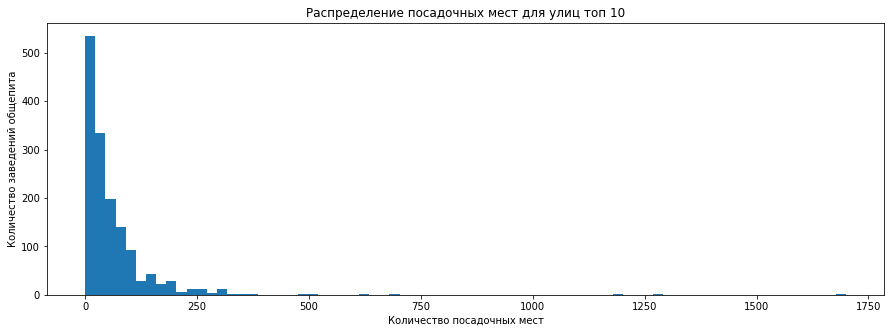

In [262]:
plt.figure(figsize = (15,5))
plt.hist(rest_moscow10['number'],bins=75); 
plt.title('Распределение посадочных мест для улиц топ 10');
plt.xlabel('Количество посадочных мест')
plt.ylabel('Количество заведений общепита')
plt.show()
plt.show()

Хотя, конечно, есть заведения  с 1500 и 1700 местами, но абсолютный максимум заведений с небольшим количеством посадочных мест.

## Выводы и предложения

В процессе подготовки данных для анализа были структурированы адреса заведений общественного питания, затем проведена проверка на дубли, удалены 170 двойных и более записей. Оставлены те из них, у которых было большее количество посадочных мест. 

**Общий вывод** В процессе исследования типов и расположения объектов питания г. Москвы можно сделать вывод, что если рассматривать Москву с пригородами, то по типам объектов питания абсолютное первенство приходится на кафе. А далее с большим отрывом уже идут столовая, ресторан и предприятие быстрого обслуживания.Как показывают исследования, они присутствуют во всех районах, и можно предположить, что, как во всех больших городах, объекты питания сконцентрированы в центре и вдоль основных магистралей, что и демонстрирует выборка топ10.  

	проспект Мира	        197
    Профсоюзная улица	    181
    Ленинградский проспект	172
    Пресненская набережная	165
	Варшавское шоссе	    161
    Ленинский проспект	    148
	проспект Вернадского	127
    Кутузовский проспект	114
    Каширское шоссе	        110
	Кировоградская улица	107

Топ 10 районов, где больше всего улиц с одним заведением

    Таганский район        27
    Район Хамовники        26
    Басманный район        25
    Тверской район         20
    Пресненский район      20
    Район Марьина роща     18
    Район Арбат            18
    Район Сокольники       15
    Мещанский район        15
    Район Замоскворечье    14

Среднее (по медиане) количество посадочных мест в зависимости от типа заведения

103 - столовая	
 80 - ресторан	
 35 - бар	
 32 - буфет	
 32 - кафе	
  6 - кафетерий	
  6 - предприятие быстрого обслуживания	
  0 - закусочная	
  0 - магазин (отдел кулинарии)	

**Рекомендации** В нашем случае речь идет о небольшом заведении оригинального формата. Трудно представить себе авторское кафе или ресторан, где все операции выполняют роботы, поэтому я бы предложила рассмотреть вариант предприятия быстрого обслуживания, тем более, что этот вид по распространенности стоит на четвертом месте, а значит ниша далеко не заполнена. 

В качестве места первоначального базирования я бы предложила рассмотреть город Зеленоград. Главный аргумент, что там находится знаменитый МИЭТ. А значит есть специалисты по интересующему профилю и может быть организована реальная работа для студентов по совершенствованию функционала роботов при разработке ПО. И немаловажный аргумент для старт-апа - аренда помещения дешевле, чем в Москве. Этот вариант смог бы быть своего рода полигоном, тестовой площадкой, и после обкатки технологий можно было бы  перенести эту экзотику (или масштабировать как сетевой вариант) в туристические районы Москвы.  

## Обзор заведений общественного питания Зеленограда

Для общей картины сделаем обзор заведений общественного питания Зеленограда.Отберем в отдельный файл объекты Зеленограда и повторим все выкладки, сделанные для общего обзора. 

In [263]:
rest_green = rest_data[rest_data['a0']=='город Зеленоград']
rest_green

,id,object_name,chain,object_type,address,number,a0,a1,a2,a3,a4,a5
23,28600,СТОЛОВАЯ МИЭТ,нет,столовая,"город Москва, город Зеленоград, площадь Шокина...",520,город Зеленоград,площадь Шокина,дом 1,,,
223,124698,Столовая в школе 2045 корп. 2312,нет,столовая,"город Москва, город Зеленоград, корпус 2312",290,город Зеленоград,корпус 2312,,,,
231,59380,Корчма Диканька,нет,ресторан,"город Москва, город Зеленоград, Савёлкинский п...",286,город Зеленоград,Савёлкинский проезд,дом 12,,,
668,23379,НИИМЭ И ЗАВОД МИКРОН,нет,столовая,"город Москва, город Зеленоград, 1-й Западный п...",230,город Зеленоград,1-й Западный проезд,дом 12,строение 1,,
744,24024,Кафе Пронто,да,кафе,"город Москва, город Зеленоград, корпус 1549",220,город Зеленоград,корпус 1549,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
13932,184516,КалаЧ,нет,магазин (отдел кулинарии),"город Москва, город Зеленоград, корпус 1550",0,город Зеленоград,корпус 1550,,,,
14051,220587,Пицца Паоло,да,кафетерий,"город Москва, город Зеленоград, корпус 1627",0,город Зеленоград,корпус 1627,,,,
14347,192748,Доставка Японской кухни Banzai sheff,нет,предприятие быстрого обслуживания,"город Москва, город Зеленоград, корпус 1455",0,город Зеленоград,корпус 1455,,,,
14626,200637,Кафе «Лайк»,нет,кафетерий,"город Москва, город Зеленоград, улица Гоголя, ...",0,город Зеленоград,улица Гоголя,дом 2,,,


In [264]:
rest_green_count = rest_green['object_type'].value_counts().reset_index()
rest_green_count.columns= ['object_type','object_count']

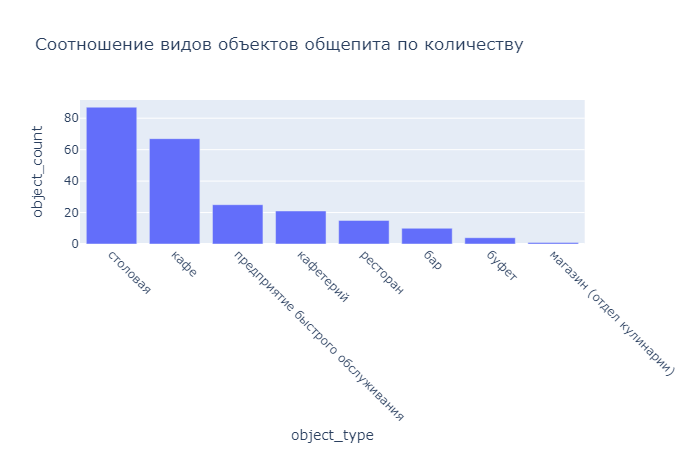

In [265]:
data = rest_green_count
fig = px.bar(
    data, x='object_type', y='object_count',
    title='Cоотношение видов объектов общепита по количеству'
)
fig.update_xaxes(tickangle=45)
fig.show('png') 

В отличие от общей картины по Москве здесь количество столовых превышает количество кафе.

In [266]:
rest_green_chain_count = rest_green.groupby(['chain','object_type'])['id'].count().reset_index()
rest_green_chain_count.columns = ['chain','object_type','object_count']
rest_green_chain_count = rest_green_chain_count.sort_values(by=['chain','object_count'],ascending = False)
rest_green_chain_count

,chain,object_type,object_count
12,нет,столовая,87
7,нет,кафе,54
8,нет,кафетерий,20
10,нет,предприятие быстрого обслуживания,10
5,нет,бар,9
11,нет,ресторан,9
6,нет,буфет,4
9,нет,магазин (отдел кулинарии),1
3,да,предприятие быстрого обслуживания,15
1,да,кафе,13


In [267]:
chain_green_no = rest_green_chain_count[rest_green_chain_count['chain']=='нет']
chain_green_no.columns = ['chain','object_type','object_chain_no']
chain_green_yes = rest_green_chain_count[rest_green_chain_count['chain']=='да']
chain_green_yes.columns = ['chain','object_type','object_chain_yes']
marks_green_chain = chain_green_no.merge(chain_green_yes,on='object_type')
marks_green_chain['part_y'] = (marks_green_chain['object_chain_yes']/(marks_green_chain['object_chain_no']+marks_green_chain['object_chain_yes'])).round(2)   
marks_green_chain[['object_type','object_chain_no','object_chain_yes','part_y']]

,object_type,object_chain_no,object_chain_yes,part_y
0,кафе,54,13,0.19
1,кафетерий,20,1,0.05
2,предприятие быстрого обслуживания,10,15,0.60
3,бар,9,1,0.10
4,ресторан,9,6,0.40


In [268]:
print('Количество несетевых заведений=',marks_green_chain['object_chain_no'].sum())
print('Количество сетевых заведений=',marks_green_chain['object_chain_yes'].sum())

Количество несетевых заведений= 102
Количество сетевых заведений= 36


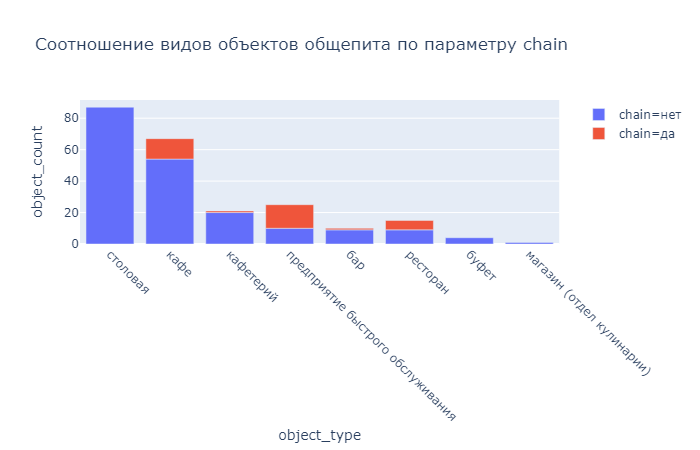

In [269]:
fig = px.bar(
    rest_green_chain_count,
    x='object_type',
    y='object_count',
    color='chain',
    title='Cоотношение видов объектов общепита по параметру chain'
)
fig.update_xaxes(tickangle=45)
fig.show('png')

In [270]:
numbers_green=rest_green.groupby('object_type')['number'].median().reset_index()
numbers_green.columns=['object_type','number']
numbers_green=numbers_green.sort_values(by='number',ascending=False)
numbers_green

,object_type,number
7,столовая,100
6,ресторан,90
0,бар,49
2,кафе,35
5,предприятие быстрого обслуживания,30
1,буфет,7
3,кафетерий,6
4,магазин (отдел кулинарии),0


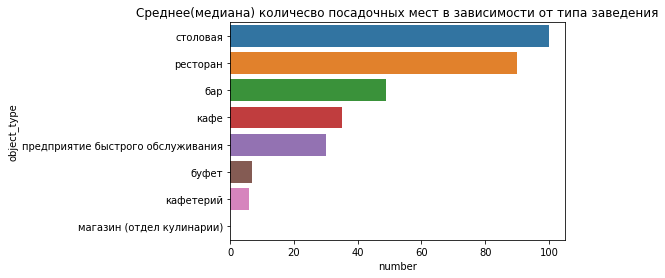

In [271]:
sns.barplot(x='number', y='object_type', data=numbers_green).set_title('Среднее(медиана) количесво посадочных мест в зависимости от типа заведения');

## Заключение

Как видно на полученных графиках, они отличаются от общей картины по Москве. На первом месте здесь находятся столовые (в основном студенческие и школьные), кафе на втором месте, а предприятия быстрого обслуживания - на третьем месте, причем большая часть представлена в сетевом варианте,  и все равно их меньше вполовину, чем кафе. Причем в отличие от общей ситуации по Москве здесь отсутствуют закусочные, а магазин-кулинария всего 1. Тоже вариант: из автомата при кафе можно продавать упакованные салатики, выпечку и полуфабрикаты. 

По аналогии с Москвой можно посмотреть топ10 улиц, но это будет не очень точно, потому что многие адреса представлены только номером корпуса, возможно, учебного. Или может в Зеленограде все уже оцифровано и робототизировано?

In [272]:
groupped_streets_z=rest_green.groupby(['a1'])['id'].count().reset_index()
groupped_streets_z.columns=['street','count']
groupped_streets_z.sort_values(by='count',ascending=False).head(10)

,street,count
6,Крюковская площадь,11
10,Панфиловский проспект,9
130,проспект Генерала Алексеева,7
127,площадь Юности,7
15,Сосновая аллея,6
13,Савёлкинский проезд,6
0,1-й Западный проезд,5
126,площадь Шокина,5
135,улица Юности,5
8,Новокрюковская улица,5


Полученные данные по Зеленограду подтверждают, что можно рассмотреть этот вариант базирования как вероятный.

Презентация исследования для инвесторов. Когда получила задание, думала, что кафе с роботами - это шутка. Оказывается такие уже существуют.  

Презентация:https://disk.yandex.ru/i/oD3Ka3CV_eyX7Q